# Bartsz Konopka - Laboratorium nr 3 - grupa 2

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ZAD 1

## Kod

Treść:

Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

Proszę pamiętać, że zadanie może wymagać odpowiedniego czasu na obliczenia. Nie polecamy wykonywać go na komputerach uczelnianych, tylko wykorzystać zasoby colaba (albo własne, jeśli państwo chcą). Ewentualne przyśpieszenie obliczeń można uzyskać korzystając z GPU w colabie, jeżeli nie dysponują państwo kartą NVidii albo nie chcą jej państwo używać (opisane w zadaniu 2*)

In [3]:
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])

batch_size = 4

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

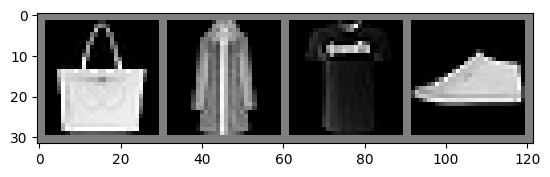

Bag   Coat  T-shirt/top Sneaker


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [94]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 20, 5)
        self.fc1 = nn.Linear(20 * 4 * 4, 160)
        self.fc2 = nn.Linear(160, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net1 = Net1()
net2 = Net2()
net3 = Net3()

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)
optimizer3 = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

In [96]:
def train(net, criterion, optimizer, epochs=5):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                losses.append(running_loss / 2000)
                running_loss = 0.0
    print('Finished Training')
    return losses

In [97]:
def test(net):
    correct = 0
    total = 0
    confusion_matrix = np.zeros((10, 10), dtype=int)
    misclassified_images = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                confusion_matrix[labels[i]][predicted[i]] += 1
                if predicted[i] != labels[i] and len(misclassified_images) < 1:
                    misclassified_images.append((images[i], labels[i], predicted[i]))

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    print("Confusion Matrix:")
    print(confusion_matrix)

    for idx, (image, true_label, predicted_label) in enumerate(misclassified_images):
        print("Misclassified Image {}:".format(idx + 1))
        imshow(torchvision.utils.make_grid(image))
        print('True Label: {}'.format(classes[true_label]))
        print('Predicted Label: {}'.format(classes[predicted_label]))
        plt.show()


In [100]:
losses1 = train(net1, criterion, optimizer1, epochs=2)

[1,  2000] loss: 1.186
[1,  4000] loss: 0.651
[1,  6000] loss: 0.558
[1,  8000] loss: 0.525
[1, 10000] loss: 0.488
[1, 12000] loss: 0.442
[1, 14000] loss: 0.434
[2,  2000] loss: 0.392
[2,  4000] loss: 0.385
[2,  6000] loss: 0.387
[2,  8000] loss: 0.382
[2, 10000] loss: 0.369
[2, 12000] loss: 0.357
[2, 14000] loss: 0.347
Finished Training


In [99]:
losses2 = train(net2, criterion, optimizer2, epochs=2)

[1,  2000] loss: 1.433
[1,  4000] loss: 0.673
[1,  6000] loss: 0.573
[1,  8000] loss: 0.502
[1, 10000] loss: 0.477
[1, 12000] loss: 0.433
[1, 14000] loss: 0.408
[2,  2000] loss: 0.372
[2,  4000] loss: 0.373
[2,  6000] loss: 0.358
[2,  8000] loss: 0.344
[2, 10000] loss: 0.361
[2, 12000] loss: 0.349
[2, 14000] loss: 0.336
Finished Training


In [98]:
losses3 = train(net3, criterion, optimizer3, epochs=2)

[1,  2000] loss: 2.302
[1,  4000] loss: 2.081
[1,  6000] loss: 1.058
[1,  8000] loss: 0.844
[1, 10000] loss: 0.751
[1, 12000] loss: 0.701
[1, 14000] loss: 0.648
[2,  2000] loss: 0.603
[2,  4000] loss: 0.588
[2,  6000] loss: 0.565
[2,  8000] loss: 0.528
[2, 10000] loss: 0.515
[2, 12000] loss: 0.533
[2, 14000] loss: 0.497
Finished Training


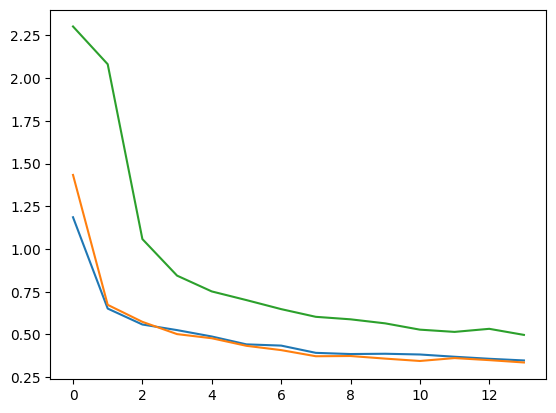

In [101]:
plt.plot(losses1)
plt.plot(losses2)
plt.plot(losses3)
plt.show()

Accuracy of the network on the 10000 test images: 86 %
Confusion Matrix:
[[821   1   8  43   4   2 113   0   8   0]
 [  0 969   0  19   3   1   6   0   2   0]
 [ 14   0 764  12 129   1  76   0   4   0]
 [ 16   4   2 929  17   0  30   0   1   1]
 [  1   1  69  49 833   0  46   0   1   0]
 [  0   0   0   2   0 941   0  38   0  19]
 [154   1  97  39 122   0 577   0  10   0]
 [  0   0   0   0   0   3   0 961   0  36]
 [  3   2   8   8   3  15   9   7 944   1]
 [  0   0   0   0   0   4   0  36   0 960]]
Misclassified Image 1:


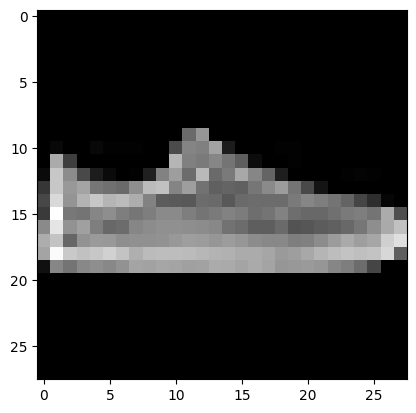

True Label: Sneaker
Predicted Label: Sandal
Accuracy of the network on the 10000 test images: 87 %
Confusion Matrix:
[[835   1   7  32   4   2 113   0   6   0]
 [  0 971   0  20   3   1   4   0   1   0]
 [ 18   1 747   8  83   0 141   0   2   0]
 [ 17   6   7 900  22   0  45   0   3   0]
 [  1   2  56  36 784   0 120   0   1   0]
 [  0   0   0   0   0 966   0  22   0  12]
 [137   1  52  25  76   0 695   0  14   0]
 [  0   0   0   0   0  19   0 944   0  37]
 [  4   2   4   5   3   4   4   5 969   0]
 [  0   0   0   0   0   4   0  31   1 964]]
Misclassified Image 1:


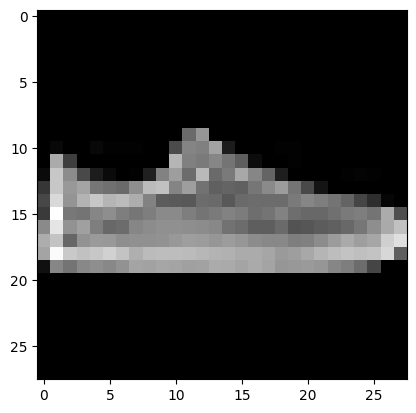

True Label: Sneaker
Predicted Label: Sandal
Accuracy of the network on the 10000 test images: 80 %
Confusion Matrix:
[[809   1  33  85   7   5  33   0  27   0]
 [  1 953   2  32   9   1   0   0   2   0]
 [ 12   1 542   9 190   0 235   0  11   0]
 [ 20  11  15 853  68   0  25   1   7   0]
 [  1   0  31  43 749   0 170   0   6   0]
 [  0   1   0   1   0 922   0  57   1  18]
 [231   3  70  68 163   0 424   0  41   0]
 [  0   0   0   0   0  20   0 965   0  15]
 [  2   1   4   3   5   6  10   5 962   2]
 [  0   0   0   0   0   9   0 102   0 889]]
Misclassified Image 1:


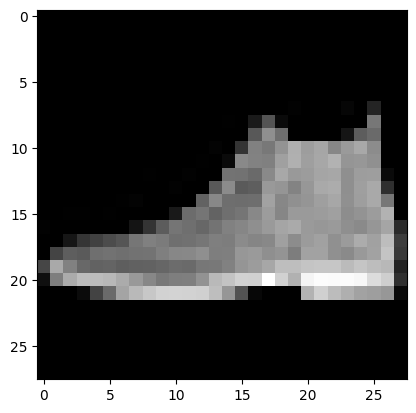

True Label: Ankle boot
Predicted Label: Sneaker


In [102]:
test(net1)
test(net2)
test(net3)

## Wnioski

Architektura sieci neuronowych odgrywa istotną rolę w procesie klasyfikacji danych. W naszym zadaniu zastosowaliśmy trzy różne architektury oznaczone jako Net1, Net2 i Net3. Każda z tych architektur posiadała unikalną liczbę warstw oraz różne parametry konwolucyjne i liniowe. W trakcie trenowania sieci neuronowych niezwykle istotne jest odpowiednie dobranie hiperparametrów, takich jak współczynnik uczenia (learning rate), momentum oraz liczba epok. W naszym przypadku zastosowaliśmy te same hiperparametry dla każdej z architektur: lr=0.001, momentum=0.9 oraz 2 epoki trenowania. Wykresy funkcji strat podczas procesu uczenia ukazują spadek wartości funkcji straty w kolejnych epokach dla wszystkich trzech sieci, co sugeruje prawidłowy przebieg procesu uczenia. Analiza macierzy pomyłek pozwala na ocenę skuteczności każdej z sieci w klasyfikacji poszczególnych klas. Warto zauważyć obszary, w których sieci miały największe trudności w dokładnej klasyfikacji. Przykłady błędnie sklasyfikowanych obrazów dla każdej z sieci pokazują, że nawet dla prostych przypadków sieci mogą popełniać błędy, co sugeruje istnienie obszarów, w których modele mogą wymagać dalszej optymalizacji. Podsumowując, analiza wyników pozwala na porównanie skuteczności różnych architektur sieci neuronowych oraz identyfikację obszarów, które mogą wymagać dalszego dostosowania w celu poprawy jakości klasyfikacji.